<a href="https://colab.research.google.com/github/jfjoung/AI_For_Chemistry/blob/main/notebooks/week12/Week_12_Bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🎯 학습 목표 (Learning Objectives)

- Bayesian Optimization의 개념과 필요성을 이해하고,  
  이를 통해 실험적 반응 조건(촉매, 리간드, 염기, 용매 등)을 효율적으로 탐색하는 전략을 배운다.

- Gaussian Process 기반의 surrogate model과 acquisition function (특히 Expected Improvement)의 역할을 이해하고,  
  이들이 어떻게 사용되어 최적 조건을 반복적으로 탐색하는지 실습을 통해 익힌다.

- 실제 Buchwald–Hartwig 반응 데이터셋을 기반으로,  
  화학 실험 최적화 문제를 머신러닝 문제로 변환하여,  
  BO 알고리즘이 실험자의 의사결정을 어떻게 보완할 수 있는지 체험한다.

- `EDBO`(Experimental Design via Bayesian Optimization) 패키지를 사용하여  
  Bayesian Optimization을 구현하고, 실험 조건을 제안하는 전체 과정을 Python 코드로 따라 실행해본다.

- 탐색 vs. 활용 (exploration vs. exploitation) 개념을 체감하고,  
  Bayesian Optimization이 적은 실험 횟수로 고수율 조건을 찾아내는 과정을 시각적으로 확인한다.


In [ ]:
!pip install scikit-learn-extra pytorch_lightning transformers botorch gpytorch rdkit numpy==1.26
!pip install --no-deps rxnfp
!pip install --no-deps drfp

In [ ]:
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week12/utils.py -O utils.py
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week12/bh-reactions.csv -O bh-reactions.csv
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week12/tanimoto_kernel.py -O tanimoto_kernel.py
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week12/base_fingerprint_kernel.py -O base_fingerprint_kernel.py

In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
import pandas as pd
import torch

# 📘 소개 (Introduction)

이 노트북에서는 화학 반응의 수율(yield)을 최대화하는 최적화 문제를 다룹니다.  
특히 유기화학에서 **탄소–질소 결합 형성에 널리 사용되는 Buchwald–Hartwig 반응**을 중심으로 살펴봅니다.  
이 반응의 수율은 **리간드(ligand), 염기(base), 첨가제(additive), 아릴 할라이드(aryl halide)** 등 다양한 조건에 따라 달라지기 때문에,  
최적화는 고차원(high-dimensional)이고 복잡한 문제로 이어집니다.

우리가 사용할 데이터셋은 총 **5가지 반응 조건 조합**, 약 **790개의 실험 결과**로 구성되어 있어,  
최적화를 위한 풍부한 정보를 제공합니다.  
하지만 변수 수가 많기 때문에, 전통적인 최적화 방법은 **비효율적이거나 실질적으로 불가능**할 수 있습니다.

이 문제를 해결하기 위해 우리는 **Bayesian Optimization (BO)** 을 사용합니다.  
BO는 블랙박스 함수의 전역 최적화를 위한 강력한 도구로,  
전통적인 최적화처럼 모든 경우를 일일이 실험하지 않고도 **데이터 효율적인 방식으로 최적 조건을 탐색**할 수 있습니다.  
이는 **실험 하나하나가 비용이 많이 드는 화학 반응 최적화 문제에 특히 잘 맞는 접근**입니다.

이 노트북에서는 Buchwald–Hartwig 데이터셋을 사용하여  
Bayesian Optimization이 **무작위 탐색(random search)** 보다 얼마나 효율적인지를 비교 실험을 통해 보여줄 것입니다.  
BO는 적은 횟수의 실험만으로도 수율을 극대화하는 최적 조건에 도달할 수 있는 효과적인 방법임을 확인할 수 있습니다.


## 🔍 단일 변수 반응 최적화: 온도 조건에서의 Bayesian Optimization 예제

우리는 가장 단순한 경우로서 **온도 하나만 조절 가능한 반응 조건**을 가정하고,  
수율(yield)을 최대화하기 위한 **Bayesian Optimization의 작동 원리**를 시각적으로 살펴봅니다.

총 3개의 관측된 실험 데이터를 기반으로, Gaussian Process를 학습하고,  
이후 예측 결과를 기반으로 **UCB (Upper Confidence Bound)** 를 계산하여  
다음 실험을 어디서 수행해야 가장 유망할지를 파악해봅니다.

- 관측값: \( x = 온도), \( y = 수율 \)
- 목표: \( y = f(x) \)의 최댓값을 찾는 것
- 사용 모델: Gaussian Process (scikit-learn)
- 사용 전략: UCB 기반 탐색


### 데이터를 추가한다면 바로 아래 칸에 데이터를 수정할 것!

In [ ]:
# 1. 관측된 데이터 정의
X_obs = np.array([[20.0], [60.0], [150.0]])  # 온도 (°C)
y_obs = np.array([5.0, 60.0, 55.0])          # 수율 (%)

In [ ]:
# 2. 수율을 0~1 사이로 스케일링
y_scaled = y_obs / 100.0

# 3. 테스트할 온도 구간 (0~180°C 사이를 500등분)
X = np.linspace(0, 180, 500).reshape(-1, 1)

In [ ]:
# 4. Gaussian Process 모델 정의 및 학습

# RBF(Radial Basis Function) 커널 정의
# length_scale은 곡선이 얼마나 부드러운지를 조절하는 하이퍼파라미터
# 값이 작을수록 국소적으로 휘고, 클수록 완만한 곡선을 생성함
kernel = RBF(length_scale=10)

# Gaussian Process 회귀 모델 생성
# 커널은 위에서 정의한 RBF 커널을 사용하고, noise-free 조건 (기본 alpha=1e-10)
gp_scaled = GaussianProcessRegressor(kernel=kernel)

# 측정 오차가 표준편차 약 5% 정도 있다고 가정하면 아래 처럼 alpha에 해당 표준편차를 기입
# gp_scaled = GaussianProcessRegressor(kernel=kernel, alpha=0.05**2)

# 관측된 데이터(X_obs, y_scaled)를 이용해 GP 모델 학습
# 학습 후, 모델은 입력 x에 대해 예측 평균과 불확실성(표준편차)을 추정할 수 있음
gp_scaled.fit(X_obs, y_scaled)


# 5. 예측값(평균과 표준편차) 계산

# 테스트 구간 X(0~180°C)에 대해 예측 수행
# return_std=True 옵션을 주면 표준편차(불확실성)도 함께 반환함
mu_scaled, std_scaled = gp_scaled.predict(X, return_std=True)

# 예측 평균과 표준편차를 0~100% 스케일로 복원 (학습 시 0~1로 나눴기 때문)
mu = mu_scaled * 100
std = std_scaled * 100


# 6. UCB 계산

# Upper Confidence Bound 계산: 평균 + beta * 표준편차
# 평균이 크거나, 표준편차(불확실성)가 큰 영역을 우선적으로 탐색함
beta = 1.96  # 95% 신뢰구간에 해당하는 계수 (탐색 vs 활용 밸런스를 조정)
ucb = mu + beta * std

# UCB가 최대가 되는 위치를 찾음 → 다음 실험 후보 온도
ucb_max_idx = np.argmax(ucb)          # UCB가 최대인 인덱스
ucb_max_temp = X[ucb_max_idx, 0]      # 해당 인덱스에 대응되는 온도 값
ucb_max_value = ucb[ucb_max_idx]      # 해당 지점의 UCB 값
print(f"UCB가 최대가 되는 다음 추천 실험 온도: {ucb_max_temp:.2f}°C")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10/1.5, 8/1.5), height_ratios=[3, 1], sharex=True)

# 위: 평균 + gradient 신뢰구간
ax1.plot(X, mu, 'k-', label='Predicted expectation')
for i in range(1, 21):
    alpha = 0.1 * (1 - (i - 1) / 20)
    k = i / 20 * 1.96
    ax1.fill_between(X.ravel(), mu - k * std, mu + k * std, color='blue', alpha=alpha)

ax1.scatter(X_obs, y_obs, c='red', s=100, zorder=10, label='Recorded yield', edgecolors='k')
ax1.set_ylabel('Yield (%)')
ax1.set_ylim(-5, 105)
ax1.set_xlim(0, 180)
ax1.grid(True)

# 아래: UCB 곡선
ax2.plot(X, ucb, color='darkorange', label='UCB(x)')
ax2.set_title('Upper Confidence Bound (UCB)')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('UCB(x)')
ax2.set_ylim(-5, None)
ax2.set_xlim(0, 180)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## 🔁 Gaussian Process 기반 예측과 UCB를 이용한 최적화 흐름

위의 시각화에서 볼 수 있듯이, Gaussian Process (GP)를 이용하면 온도에 따른 수율의 추세를 추정할 수 있습니다.  
또한, 예측값의 불확실성(표준편차)을 활용하여 **Upper Confidence Bound (UCB)** 를 계산하고,  
가장 UCB가 큰 지점을 **다음 실험 후보 온도**로 제안할 수 있습니다.

### ✅ 주의할 점

- GP는 함수 전체의 분포를 확률적으로 추정할 뿐이며,  
  **실제 수율이 0% 미만이거나 100%를 초과하는 것처럼 예측될 수도 있습니다.**
- 이것은 **모델이 확률적으로 "그럴 수도 있다"고 생각하는 것이지,  
  화학적으로 가능한 결과라는 뜻은 아닙니다.**
- 따라서 모델의 예측값은 **물리적 제약(예: 수율은 0~100%)을 직접 반영하지 않습니다.**

### 🔄 Bayesian Optimization의 순환 구조

1. **UCB가 최대인 지점을 선택**
2. **해당 온도에서 실험 수행**
3. **실험 수율 결과를 관측 데이터에 추가**
4. **GP 모델을 다시 학습하고 UCB 재계산**
5. **다시 가장 유망한 지점 탐색 → 반복**

이 과정을 반복하면, 점점 더 **신뢰도 높은 예측**이 가능해지고  
최적 조건(최고 수율 온도)에 가까워질 수 있습니다.

---

💡 **이 방식은 실험의 수가 제한적인 화학 최적화 문제에 특히 유용**합니다.  
탐색이 중요한 초반에는 불확실성이 큰 구간을 중심으로,  
활용이 중요한 후반에는 예측값이 높은 구간 중심으로 실험을 추천하는 구조입니다.


# Data loading

In [ ]:
data = pd.read_csv('bh-reactions.csv')
print(len(data['reaction'].unique()))
data.head()

0번 reaction

<p align="middle">
  <img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/BH_reaction.png" width="600"/>
</p>

## 🧮 실험 디자인 공간 (Design Space)

이 데이터셋에서 다루는 각 반응은 다음의 조합 가능한 조건들로 구성되어 있습니다:

- **리간드 (ligand)**: 4종  
- **첨가제 (additive)**: 22종  
- **염기 (base)**: 3종  
- **아릴 할라이드 (aryl halide)**: 3종

따라서 총 가능한 조합 수는 다음과 같이 계산됩니다:

$\displaystyle 4 \times 22 \times 3 \times 3 = 792 \text{ combinations}$

즉, **각 반응마다 총 792개의 실험 조건 조합**이 존재하며, 이를 전부 실험하는 것은 시간과 비용 측면에서 비효율적입니다.  
이러한 고차원 조합 공간에서 최적 조건을 빠르게 찾기 위해 **Bayesian Optimization**이 활용됩니다.


## 🧪 Data Featurization

Bayesian Optimization을 적용하려면, 원시 데이터를 머신러닝 모델이 처리할 수 있는 형식으로 변환해야 합니다.  
이러한 과정을 **data featurization** 라고 합니다.  
화학 반응 데이터를 위한 featurization 방법에는 여러 가지가 있으며,  
각 방법은 **계산 비용**과 **예측 정확도** 측면에서 서로 다른 트레이드오프를 가집니다.

### 🔹 Density Functional Theory (DFT)

DFT는 화학 반응을 표현하기 위해 자주 사용되는 계산화학적 방법입니다.  
분자의 전자 구조를 정밀하게 계산할 수 있으며, **높은 정확도**를 자랑합니다.  
하지만 계산 비용이 매우 높기 때문에, **고속 실험 최적화와는 궁합이 좋지 않을 수 있습니다.**

---

### 🔹 빠른 Featurization를 위한 방법들

실용성과 계산 효율성을 위해, 여러 가지 **fingerprinting 방법**이 사용됩니다.  
이들은 화학 구조를 **고정 길이의 수치 벡터(fingerprint)** 로 변환하여 핵심 특성을 포착합니다.

#### • One-Hot Encoding (OHE)

- OHE는 가장 단순하고 빠른 특징화 방법입니다.  
- 범주형 변수(예: 리간드 종류, 염기 종류 등)에 대해 사용되며,  
  각 범주를 1과 0으로 이루어진 이진 벡터로 표현합니다.  
- 계산이 매우 빠르지만, **범주 간의 유사성이나 관계는 반영되지 않습니다.**

#### • DRFP (Differential Reaction Fingerprint)

- SMILES 형식으로 표현된 반응식을 입력으로 받아, 이진 벡터를 생성합니다.  
- 반응식의 화살표 좌우에 있는 분자들의 **circular molecular n-gram** 차이를 이용해 fingerprint를 구성합니다.  
- **reactant와 reagent를 구분하지 않고** 처리한다는 특징이 있습니다.

#### • RXNFP (Reaction Fingerprint)

- Transformer 기반의 **deep learning 모델**을 사용해,  
  반응식을 연속적인 벡터로 인코딩하는 **데이터 기반 특징화 방법**입니다.  
- 사전 학습된 모델을 활용하여 분자의 구조와 반응성 사이의 복잡한 관계를 효율적으로 표현할 수 있습니다.  
- 높은 적응성과 성능 덕분에, **Bayesian Optimization에 특히 적합**한 방법으로 평가됩니다.

---

이 노트북에서는 위에서 소개한 다양한 featurization 방법들을 비교하고,  
Bayesian Optimization에서 각각의 성능을 비교해 볼 예정입니다.


## One-Hot encoding (OHE)

In [ ]:
from utils import one_hot

ohe_features = one_hot(data[data['reaction']==0][['ligand','additive', 'base', 'aryl halide']])
ohe_features.shape

## DRFP (Differential Reaction Fingerprint)

In [ ]:
from utils import drfp

drfp_features = drfp(data[data['reaction']==0]['rxn'])
drfp_features.shape

## RXNFP (Reaction Fingerprint)

In [ ]:
from utils import rxnfp

rxnfp_features = rxnfp(data[data['reaction']==0]['rxn'])
rxnfp_features.shape

## 📊 Data Selection (초기 데이터 선택)

어디선가는 시작해야 하니까요. 🤷

전체 탐색 공간의 크기가 매우 클 수 있지만,  
Bayesian Optimization(BO)을 시작하려면 가능한 조합 중에서 **일부 소규모 샘플**을 먼저 선택해야 합니다.  
이 **초기 샘플 선택 방식**은 BO 전체의 성패에 큰 영향을 미칠 수 있기 때문에,  
단순히 랜덤으로 선택하는 것은 바람직하지 않을 수 있습니다.

초기 데이터를 **더 다양하게(diverse)** 선택하기 위한 대표적인 전략으로는 다음과 같은 방법들이 있습니다:

- **클러스터링(clustering)**: 조건 공간을 클러스터로 나누고 각 클러스터에서 대표 샘플을 선택
- **maximin strategy**:  
  하나의 점을 무작위로 선택한 뒤,  
  나머지 점들은 **서로 간의 최소 거리를 최대화**하도록 선택하는 방식

이러한 전략들은 **초기 데이터 세트가 조건 공간을 고르게 커버**하도록 도와주며,  
BO의 효율적인 탐색을 가능하게 합니다.


In [ ]:
import torch
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

class BOInitData:
    def __init__(self,
                 n: int = 10,                     # 선택할 초기 샘플 개수
                 method: str = 'random',          # 초기 샘플링 방법 (random, kmeans, kmedoids, max_min_dist)
                 metric: str = 'jaccard',         # 거리 계산에 사용할 메트릭 (kmedoids, max_min_dist용)
                 cluster_init: str = 'random',    # 클러스터 초기화 방법 ('random' 또는 'k-means++' 등)
                 seed: int = 42):                 # 랜덤 시드를 고정하여 재현성 확보
        self.n = n
        self.method = method
        self.seed = seed
        self.metric = metric
        self.cluster_init = cluster_init

        # 문자열로 지정한 방법을 내부 함수와 연결해주는 딕셔너리
        self.method_map = {
            'kmedoids': self.kmedoids,
            'kmeans': self.kmeans,
            'max_min_dist': self.max_min_dist,
            'random': self.random,
        }

    def fit(self, x):
        # 선택된 방법에 따라 해당 초기화 함수 호출
        init_method = self.method_map.get(self.method)
        if init_method is None:
            raise ValueError(f"Unrecognized initialization method '{self.method}'")  # 잘못된 method일 경우 예외 발생
        return init_method(x)

    def kmedoids(self, x):
        # K-Medoids 알고리즘을 사용하여 중심점을 선택
        kmedoids = KMedoids(
            n_clusters=self.n,
            init=self.cluster_init,
            random_state=self.seed,
            metric=self.metric,
            max_iter=5000,
        ).fit(x)
        # 선택된 중심점 인덱스를 텐서로 반환
        selected = torch.tensor(kmedoids.medoid_indices_.tolist())
        return selected

    def kmeans(self, x):
        # KMeans를 사용하여 중심점에 가장 가까운 점 선택
        scaler = StandardScaler()                       # 스케일링 (평균 0, 분산 1) 수행
        x_init_normalized = scaler.fit_transform(x)     # 스케일링 적용
        kmeans = KMeans(
            n_clusters=self.n,
            init=self.cluster_init,
            random_state=self.seed,
            max_iter=5000,
        ).fit(x_init_normalized)
        centroids = torch.tensor(kmeans.cluster_centers_)   # 중심점 좌표 추출
        # 각 중심점에 가장 가까운 원본 점을 선택 (유클리드 거리 최소화)
        selected = torch.argmin(torch.norm(torch.from_numpy(x).unsqueeze(1) - centroids, dim=2), dim=0)
        return selected

    def max_min_dist(self, x):
        # max-min 거리 기반 전략: 서로 최대한 멀리 떨어진 점들 선택
        distances = cdist(x, x, metric=self.metric)                     # 전체 거리 행렬 계산
        selected = torch.tensor([torch.randint(0, distances.shape[0], (1,))])  # 첫 점은 랜덤하게 선택
        for i in range(self.n - 1):
            # 현재 선택된 점들과의 최소 거리를 기준으로, 가장 멀리 떨어진 점 선택
            coverage = torch.min(torch.tensor(distances)[:, selected], axis=1)
            selected = torch.cat([selected, coverage.argmax().unsqueeze(0)])
        return selected

    def random(self, x):
        # 데이터에서 무작위로 n개 선택
        selected = torch.randperm(len(x))[: self.n]
        return selected


In [ ]:
bo_init_data = BOInitData(method='max_min_dist', metric='jaccard')

## 📦 DataModule

이제 지금까지 다룬 모든 구성 요소들을 하나의 **DataModule**로 정리해보겠습니다.


In [ ]:
import pytorch_lightning as pl
import torch
from typing import Optional
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Bayesian Optimization을 위한 데이터 모듈 정의
class BODataModule(pl.LightningDataModule):
    def __init__(self,
        dataset: str = "buchwald-hartwig",              # 데이터셋 이름 (사용자 정의용)
        data_path: str = "bh-reactions.csv",            # CSV 파일 경로
        reaction: int = 0,                              # 사용할 반응 번호 (reaction column 기준)
        representation: str = "drfp",                   # 특징화 방법: ohe, drfp, rxnfp 중 선택
        feature_dimension: int = 2048,                  # 특징 벡터의 차원 (DRFP 기준)
        bond_radius: int = 3,                           # DRFP 계산에 사용될 반지름
        init_data: BOInitData = BOInitData(),           # 초기 데이터 선택 클래스 (랜덤, kmeans 등)
    ):
        super().__init__()                              # PyTorch Lightning의 DataModule 상속 초기화
        self.dataset = dataset
        self.data_path = data_path
        self.reaction = reaction
        self.representation = representation
        self.feature_dimension = feature_dimension
        self.bond_radius = bond_radius
        self.init_data = init_data
        self.setup()                                    # 초기 데이터 로딩 및 세팅

    # 선택된 featurization 방법에 따라 X 값 생성
    def featurize(self):
        if self.representation == "ohe":
            # 리간드, 첨가제, 염기, 아릴할라이드 → One-Hot Encoding
            self.x = one_hot(self.data[['ligand','additive', 'base', 'aryl halide']])
        elif self.representation == "drfp":
            # 반응식을 DRFP (binary fingerprint) 로 변환
            self.x = drfp(self.data['rxn'])
        elif self.representation == "rxnfp":
            # Transformer 기반 RXNFP 사용
            self.x = rxnfp(self.data['rxn'])

        # 수율(y)을 벡터 형태로 저장 (N x 1 크기)
        self.y = self.data['yield'].values.reshape(-1, 1)

    # 전체 데이터 로딩 및 초기 분할
    def setup(self, stage: Optional[str] = None) -> None:
        self.data = pd.read_csv(self.data_path)                               # CSV 로부터 전체 데이터 불러오기
        self.data = data[self.data['reaction'] == self.reaction]              # 선택된 반응 번호에 해당하는 데이터만 필터링
        self.featurize()                                                      # 선택한 방식으로 특징화 실행

        init_indices = self.init_data.fit(self.x)                             # 초기 선택할 데이터 인덱스 계산
        self.train_test_split(init_indices)                                   # 훈련/평가 데이터 분리

    # 선택된 초기 인덱스를 기준으로 train/heldout 나누기
    def train_test_split(self, init_indices):
        self.train_x = torch.from_numpy(self.x[init_indices]).to(torch.float64)   # 초기 데이터 x값 → Tensor
        self.train_y = torch.from_numpy(self.y[init_indices]).to(torch.float64)   # 초기 데이터 y값 → Tensor

        heldout_mask = torch.ones(len(self.x), dtype=torch.bool)                  # 전체에서 초기 데이터 제외할 마스크
        heldout_mask[init_indices] = False                                        # 초기 인덱스 위치 False 처리

        self.heldout_x = torch.from_numpy(self.x[heldout_mask]).to(torch.float64) # 남은 데이터 x값 → Tensor
        self.heldout_y = torch.from_numpy(self.y[heldout_mask]).to(torch.float64) # 남은 데이터 y값 → Tensor

    # PyTorch Lightning에서 사용할 train 데이터로더 반환
    def train_dataloader(self):
        train_dataset = TensorDataset(self.features[self.train_data.index], self.train_data['yield'])
        return DataLoader(train_dataset, batch_size=len(self.train_data))    # 전체 train 데이터를 한 번에 로드

    # PyTorch Lightning에서 사용할 heldout 데이터로더 반환
    def heldout_dataloader(self):
        heldout_dataset = TensorDataset(self.features[self.heldout_data.index], self.heldout_data['yield'])
        return DataLoader(heldout_dataset, batch_size=len(self.heldout_data)) # 전체 heldout 데이터를 한 번에 로드


In [ ]:
dm = BODataModule(representation='ohe')

In [ ]:
dm.train_x.shape

## 🧠 Surrogate Model (대리 모델)

이제 우리가 수집한 데이터를 바탕으로,  
반응 조건과 수율 사이의 관계를 추정해줄 **강력한 surrogate model(대리 모델)**이 필요합니다.  
이 모델은 우리가 직접 실험하지 않은 지점에서도 수율이 어떻게 나올지를 예측해주며,  
전체 함수 형태에 대한 유익한 정보를 제공합니다.

여기서는 **Botorch 라이브러리**를 사용하여  
Gaussian Process 기반의 surrogate model을 구축합니다.

모델을 만들기 위해서는:
- **훈련 데이터 (입력 x, 출력 y)** 와
- **커널 함수(kernel)**  
가 필요하며, 커널은 `gpytorch` 또는 `gauche` 라이브러리를 통해 설정할 수 있습니다.


In [ ]:
from botorch.models.gp_regression import SingleTaskGP              # 단일 목적 함수용 GP 모델
from gpytorch.kernels import Kernel, ScaleKernel                   # 커널 클래스와 스케일 커널 (커널에 스케일 조정용)
from botorch.models.transforms.outcome import Standardize          # y값(출력)을 표준화하는 변환
from botorch.models.transforms.input import Normalize              # x값(입력)을 정규화하는 변환
from tanimoto_kernel import TanimotoKernel                         # 화학 fingerprint에 적합한 Tanimoto 커널 (사용자 정의 또는 외부 구현 필요)

# Gaussian Process 모델 정의 (Botorch의 SingleTaskGP를 상속)
class GP(SingleTaskGP):
    def __init__(
        self,
        train_x: torch.Tensor,                                     # 입력 데이터 (조건)
        train_y: torch.Tensor,                                     # 출력 데이터 (수율)
        kernel: Kernel = None,                                     # 사용할 커널 함수 (예: RBF, Tanimoto 등)
        standardize: bool = True,                                  # y값을 표준화할지 여부
        normalize: bool = False,                                   # x값을 정규화할지 여부
    ):
        # 내부적으로 input/output의 차원을 설정
        self._set_dimensions(train_X=train_x, train_Y=train_y)

        # 부모 클래스(SingleTaskGP) 생성자 호출
        super().__init__(
            train_x,                                                # 훈련용 입력
            train_y,                                                # 훈련용 출력
            covar_module=ScaleKernel(base_kernel=kernel),          # 커널을 스케일 조정하여 공분산 모듈 설정
            outcome_transform=Standardize(train_y.shape[-1]) if standardize else None,  # y값 표준화 여부
            input_transform=Normalize(train_x.shape[-1]) if normalize else None,        # x값 정규화 여부
        )

        # 설정 값 저장 (재사용 또는 재초기화를 위함)
        self.kernel = kernel
        self.standardize = standardize
        self.normalize = normalize

    # 모델 재초기화 함수 (새로운 데이터로 다시 모델 생성)
    def reinit(self, train_x, train_y):
        return GP(
            train_x,                    # 새로운 입력값
            train_y,                    # 새로운 출력값
            self.kernel,                # 기존 커널 재사용
            self.standardize,           # 기존 y 표준화 설정 유지
            self.normalize,             # 기존 x 정규화 설정 유지
        )


## 🚀 BO (Bayesian Optimization) 수행하기

이제 실제로 Bayesian Optimization을 사용하여 반응 조건을 최적화하고,  
그 성능을 무작위 탐색(random search)과 비교해보겠습니다.  
전체 절차는 다음과 같은 단계로 이루어집니다:

1. **초기 데이터 포인트 선택**  
   surrogate model(Gaussian Process)을 처음 학습시키기 위해,  
   일부 데이터 포인트를 선택합니다.  
   코드 예시:
   ```python
   init_data = BOInitData(method='random', metric='jaccard', cluster_init='k-means++', seed=seed)
  ```

2. **훈련된 surrogate model과 acquisition function으로부터 추천 조건 생성**  
   모델이 예측한 UCB 등을 바탕으로 다음 실험 후보를 선택합니다.  
   코드 예시:
   ```
   best_candidate = heldout_x[best_candidate_idx]
  ```

3. **추천 조건 평가**  
실제 실험에서는 해당 조건으로 실험을 수행하고 수율을 측정해야 합니다.  
여기서는 이미 데이터셋에 수율 정보가 있으므로, 해당 값을 불러오는 방식으로 대체합니다.  

4. **새로운 포인트를 학습 데이터에 추가하고 held-out 세트에서는 제거**  
추천된 조건을 훈련 세트에 추가하고, 평가에 사용된 포인트를 held-out 세트에서 제거합니다.

  ```python
  train_x = torch.vstack([train_x, heldout_x[idx]])
  train_y = torch.vstack([train_y, heldout_y[idx]])
  heldout_x = torch.cat([heldout_x[:best_candidate_idx], heldout_x[best_candidate_idx+1:]])
  heldout_y = torch.cat([heldout_y[:best_candidate_idx], heldout_y[best_candidate_idx+1:]])
  ```

5. **모델 재학습 및 반복**  
  surrogate model을 새로 학습시킨 후, 2단계부터 다시 반복합니다.


이러한 순환 과정을 통해 BO는 점점 더 나은 조건을 찾아가며 수율을 극대화하게 됩니다.

In [ ]:
import gpytorch
from gpytorch import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from pytorch_lightning import seed_everything
from botorch.acquisition import UpperConfidenceBound

# Bayesian Optimization 실행 함수 정의
def run_bo(dm):
    train_x, train_y = dm.train_x, dm.train_y               # 학습 데이터
    heldout_x, heldout_y = dm.heldout_x, dm.heldout_y       # 아직 실험되지 않은 후보 데이터
    num_iterations = 30                                     # 반복 횟수 (BO step 수)

    # GP 모델 정의 (Tanimoto 커널 사용)
    gp = GP(train_x, train_y, kernel=TanimotoKernel())
    gp.double()                                             # 정밀도 설정 (float64)

    # GP 모델 학습을 위한 Marginal Log Likelihood 정의
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    best_value = train_y.max().item()                       # 초기 최고 수율
    best_values = [best_value]                              # 각 step마다 최고 수율 추적

    for i in range(num_iterations):
        # GP 모델 학습
        with gpytorch.settings.fast_computations(covar_root_decomposition=False):
            fit_gpytorch_mll(mll, max_retries=50)

        # UCB (Upper Confidence Bound) 획득 함수 정의
        acq_func = UpperConfidenceBound(gp, beta=0.25)
        acq_values = acq_func(heldout_x.unsqueeze(-2))      # heldout 후보들에 대해 UCB 값 계산
        best_candidate_idx = acq_values.view(-1).argmax()   # UCB가 최대인 인덱스 선택
        best_candidate = heldout_x[best_candidate_idx]      # 해당 인덱스의 후보 점 추출

        # 선택된 점을 학습 데이터에 추가
        train_x = torch.vstack([train_x, best_candidate])
        train_y = torch.vstack([train_y, heldout_y[best_candidate_idx]])

        # 해당 후보를 held-out pool에서 제거
        heldout_x = torch.cat([heldout_x[:best_candidate_idx], heldout_x[best_candidate_idx+1:]])
        heldout_y = torch.cat([heldout_y[:best_candidate_idx], heldout_y[best_candidate_idx+1:]])

        # 모델 재학습을 위한 재초기화
        gp = gp.reinit(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        # 새로운 최고 수율이 등장하면 업데이트
        new_best_value = train_y.max().item()
        if new_best_value > best_value:
            best_value = new_best_value
        best_values.append(best_value)                      # 수율 추적

    return np.array(best_values)                            # 수율 경과 반환


In [ ]:
# 무작위 탐색을 통한 반응 최적화
def run_random_search(dm):
    train_x, train_y = dm.train_x, dm.train_y
    heldout_x, heldout_y = dm.heldout_x, dm.heldout_y
    num_iterations = 30
    best_value = train_y.max().item()
    best_values = [best_value]

    for _ in range(num_iterations):
        idx = torch.randint(heldout_x.size(0), (1,))                        # heldout pool에서 무작위로 하나 선택
        train_x = torch.vstack([train_x, heldout_x[idx]])                  # train에 추가
        train_y = torch.vstack([train_y, heldout_y[idx]])
        heldout_x = torch.cat([heldout_x[:idx], heldout_x[idx+1:]])       # heldout에서 제거
        heldout_y = torch.cat([heldout_y[:idx], heldout_y[idx+1:]])

        new_best_value = train_y.max().item()
        if new_best_value > best_value:
            best_value = new_best_value
        best_values.append(best_value)

    return np.array(best_values)                                           # 수율 경과 반환


In [ ]:
from tqdm import tqdm

progress_bar = tqdm(total=9)                         # 시각적 진행률 표시줄

representations = ['ohe', 'rxnfp', 'drfp']            # 사용할 특징화 방식
reactions = [0]                                       # 사용할 반응 번호 (1~4 추가 가능)
seeds = range(3)                                     # 3번 반복 (seed 0~2)

results = {}                                          # 결과 저장 딕셔너리

# 각 특징화 방식에 대해 반복
for representation in representations:
    results[representation] = {}
    for reaction in reactions:
        results[representation][reaction] = {'bo': [], 'random': []}
        for seed in seeds:
            seed_everything(seed)                     # 랜덤 시드 고정

            # BO 수행
            dm = BODataModule(
                reaction=reaction,
                representation=representation,
                init_data=BOInitData(method='random', metric='jaccard', cluster_init='k-means++', seed=seed)
            )
            best_values_bo = run_bo(dm)

            # Random Search 수행
            dm = BODataModule(reaction=reaction, representation=representation)
            best_values_random = run_random_search(dm)

            # 결과 저장
            results[representation][reaction]['bo'].append(best_values_bo)
            results[representation][reaction]['random'].append(best_values_random)

            progress_bar.update(1)                    # 진행 표시 업데이트


## 📊 결과 시각화 (Visualization)

이제 Bayesian Optimization과 Random Search의 결과를 시각화해 보겠습니다.  
그래프로 비교해 보면, **Bayesian Optimization이 무작위 탐색보다 더 나은 성능을 보였을까요?**

---

### 🧪 추가 질문

- 다른 반응(reaction)들에 대해서도 결과를 시각화할 수 있나요?
- 어떤 현상이 관찰되나요?
- 어떤 **featurization 방식 (OHE, DRFP, RXNFP)**이 가장 좋은 성능을 보이나요?

---

### 🔁 초기 샘플 선택 방법 바꿔보기

초기 샘플을 선택하는 방식을 바꾸면 결과에 어떤 영향을 줄까요?  
(*힌트: `BODataModule` 생성 시 `init_data` 파라미터를 바꿔보세요.*)

```python
# 예시: max_min_dist 방식 사용
init_data = BOInitData(method='max_min_dist', metric='jaccard', seed=seed)


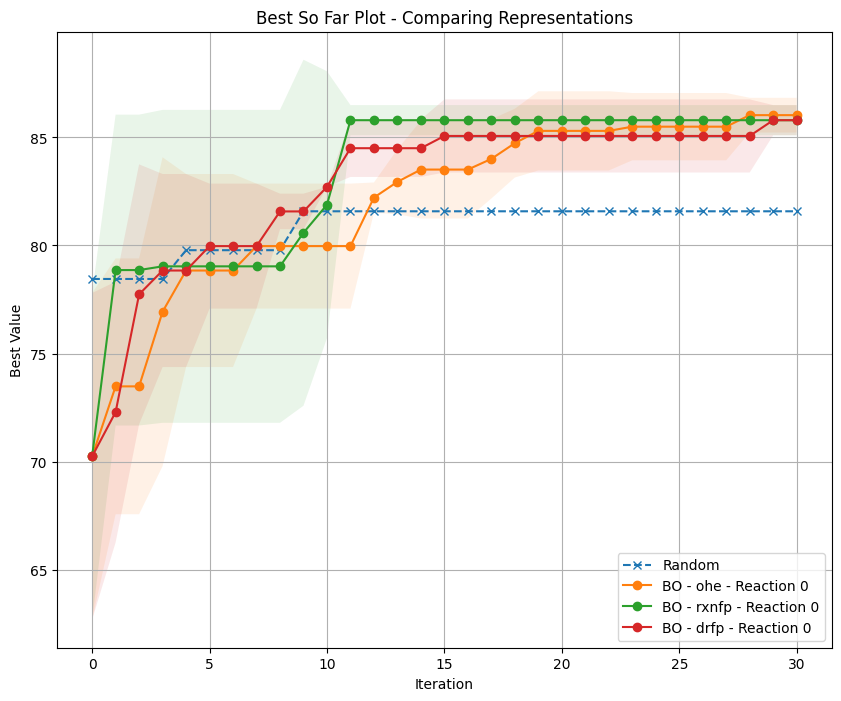

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))                    # 전체 그림 크기 설정 (가로 10, 세로 8)
reaction = 0                                   # 반응 번호 지정 (reaction 0번 기준으로 비교)

# 모든 표현 방식에 대해 random search 결과의 평균 및 표준편차 계산
mean_random = np.mean(
    [np.mean(results[rep][reaction]['random'], axis=0) for rep in representations], axis=0
)
std_random = np.std(
    [np.std(results[rep][reaction]['random'], axis=0) for rep in representations], axis=0
)

# 무작위 탐색 (random search)의 평균 성능을 선으로 표시
plt.plot(mean_random, label='Random', marker='x', linestyle='--')

# 무작위 탐색 결과의 표준편차 구간(±1σ)을 음영으로 표현
plt.fill_between(range(len(mean_random)), mean_random - std_random, mean_random + std_random, alpha=0.1)

# 각 representation(OHE, DRFP, RXNFP)에 대해 BO 결과 시각화
for representation in representations:
    for reaction in reactions:
        # BO 성능의 평균 및 표준편차 계산
        mean_bo = np.mean(results[representation][reaction]['bo'], axis=0)
        std_bo = np.std(results[representation][reaction]['bo'], axis=0)

        # BO 성능 평균 선 그래프
        plt.plot(mean_bo, label=f'BO - {representation} - Reaction {reaction}', marker='o')

        # BO의 ±1σ 표준편차 영역 음영 처리
        plt.fill_between(range(len(mean_bo)), mean_bo - std_bo, mean_bo + std_bo, alpha=0.1)

# 그래프 제목, 축 이름 및 범례 설정
plt.title("Best So Far Plot - Comparing Representations")  # 그래프 제목
plt.xlabel('Iteration')                                    # x축: BO 반복 횟수
plt.ylabel('Best Value')                                   # y축: 현재까지의 최고 수율
plt.legend()                                               # 범례 표시
plt.grid(True)                                             # 배경 격자 추가
plt.show()                                                 # 최종 시각화 출력
